In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import pyxdf
import os
import numpy as np
from scipy import stats
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
from tueplots import axes, bundles
from astropy.convolution import Gaussian1DKernel, convolve_fft

# Increase the resolution of all the plots below
bundles.beamer_moml()
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})


from utilities.utl import find_lsl_stream, find_nearest, fill_nan, get_channel_labels_ppl_xdf, axlines_with_text
from utilities.pupil_prep import *
from utilities.SingleSubjectData import SubjectData, Epochs



In [3]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [4]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c300', 'c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


In [11]:
# set params for epoch processing and plotting

cfg_pupil_plot_colors = plt.cm.viridis(np.linspace(0,1,3))
cfg_bl_times = [20,28]
cfg_bl_times.sort()
cfg_trial_times = [35,50] 
cfg_trial_times.sort()
cfg_epoch_times =  [-60,0]
cfg_epoch_times.sort()
cfg_kernel_smoothing = Gaussian1DKernel(stddev=100)
cfg_idx_eye = 21

if np.max(cfg_trial_times) > np.diff(cfg_epoch_times):
    raise ValueError ('Time window of interest ouside epoch length')

# prelocate variables
tmp_fnms = fnms
tmp_fnms =  [nm for nm in fnms if "c302" in nm] * 2
print([f.split('_')[0] for f in tmp_fnms])

id = []
n_trial = []
con_view_ang = []
con_feedback = []
per_bad_samples = []
ppl_size = []
bl_sizes = []

for f in tmp_fnms:
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    if not sub.eye:
        print(f'No pupil data found for {sub.id}')
        continue

    # skip participant if more than 25% of pupil data is artifact (Murphy, 2014)
    per_bad_diff = np.sum(np.diff(sub.eye["time_series"][:,cfg_idx_eye]) > 0.075) / len(sub.eye["time_series"][:,0]) 
    per_bad_dia = np.sum(sub.eye["time_series"][:,cfg_idx_eye] < 1.5) / len(sub.eye["time_series"][:,0])  
    if per_bad_diff > 0.25 or per_bad_dia > 0.25:
        flag_dataset_artifact = True

    # extract ppl chn names
    nms_ppl = get_channel_labels_ppl_xdf(sub.eye)

    # epoch data
    eps = Epochs(sub,sub.eye["time_series"],times=sub.eye["time_stamps"], events=sub.mrk, srate = sub.srate_ppl)
    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('end_trial', idx_start=idx_exp_start,tmin=cfg_epoch_times[0],tmax=cfg_epoch_times[1])
    eps.data[eps.data == 0] = np.nan

    # cfgs for epoched data
    ch_oi = ['diameter1_3d']
    idx_ch_oi = [nms_ppl.index(key) for key in ch_oi]   

    tmp_view_angle = eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2)

    fig, axd = plt.subplot_mosaic([['top', 'top'],['left', 'right']],
                              constrained_layout=True)
    # prep single trial pupil data
    for i in range(eps.data.shape[2]):
            
        data_median  =  np.nanmedian(eps.data[idx_ch_oi,:,i])
        data_std     = np.nanstd(eps.data[idx_ch_oi,:,i])
        lower_thresh = data_std * -1.5
        upper_thresh = data_std * 1.5

        if 0 <= i < 4:
            tmp_color = cfg_pupil_plot_colors[0]
            tmp_label = 'visual'
        elif 4 <= i < 8:
            tmp_color = cfg_pupil_plot_colors[1] 
            tmp_label = 'auditiv-visual'
        elif 8 <= i <12:
            tmp_color = cfg_pupil_plot_colors[2]
            tmp_label = 'auditiv'      
        
        id.append(sub.id)
        n_trial.append(i)

        diameter = np.squeeze(eps.data[idx_ch_oi,:,i] - data_median)

        idx_outlier = np.logical_or(diameter < lower_thresh, diameter > upper_thresh)
        idx_low_conf = eps.data[0,:,i] < 0.5

        per_bad_diff_ep = np.sum(np.diff(eps.data[cfg_idx_eye,:,i]) > 0.075) / len(eps.data[:,:,i]) 
        per_bad_dia_ep = np.sum(eps.data[cfg_idx_eye,:,i] < 1.5) / len(eps.data[:,:,i]) 
        per_bad_conf_ep = np.sum([idx_low_conf,idx_outlier]) / len(idx_low_conf)

        per_bad_samples.append(max(per_bad_diff_ep, per_bad_dia_ep, per_bad_conf_ep))

        sparse_diam = np.where(np.logical_or(idx_outlier,idx_low_conf),np.nan,diameter)

        # use kernel for convolution and interpolate NaNs
        smooth = convolve_fft(sparse_diam.T,cfg_kernel_smoothing,nan_treatment = 'interpolate', boundary = 'wrap')

        # do baseline correction
        bl_diam = np.nanmedian(sparse_diam[np.logical_and(eps.times > cfg_bl_times[0],eps.times < cfg_bl_times[1])])
        bl_sizes.append(bl_diam)
        smooth = smooth - bl_diam
        tmp_pupil_size = np.mean(smooth[np.logical_and(eps.times > cfg_trial_times[0],eps.times < cfg_trial_times[1])])
        ppl_size.append(tmp_pupil_size)

        cfg_plot_lw = 1.5
        cfg_epoch_timevec = np.linspace(-30,30,len(eps.times))

        if tmp_view_angle.iloc[i] == .02:
            ls = 'dotted'
        elif tmp_view_angle.iloc[i] == .44:
            ls = 'solid'

        if i in [0,4,8]:
            axd["top"].plot(cfg_epoch_timevec,smooth,color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls, label=tmp_label)
        else:
            axd["top"].plot(cfg_epoch_timevec,smooth,color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls)


    # info per epoch
    con_view_ang.extend(tmp_view_angle)
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])

    sub_trials = pd.DataFrame()
    sub_trials["ppl_size"] = ppl_size[-11:]
    sub_trials["feedback_condition"] = con_feedback[-11:]
    sub_trials["bl_sizes"] = bl_sizes[-11:]

    # plot all trials and histograms of BL and Pupil size
    ymin, ymax = axd["top"].get_ylim()
    xmin, xmax = axd["top"].get_xlim()
    cfg_patch_bl = patches.Rectangle((-10,ymin),np.diff(cfg_bl_times),(ymax + np.abs(ymin)),alpha = .1, color = 'grey')
    
    axd["top"].axvline(0,c='k')
    axd["top"].add_patch(cfg_patch_bl)
    axd["top"].annotate("Baseline", (np.sum([-10,-2]) * .5, ymax * .9), color='Black', weight='bold', fontsize=10, ha='center', va='top')
    axlines_with_text(axd["top"],5, 'Avg. start', axis='x')
    axlines_with_text(axd["top"],20, 'Avg. end', axis='x')
    axd["top"].set_xlabel('Time[s]')
    axd["top"].set_ylabel('Baseline corrected diameter [mm^2]')
    axd["top"].set_title(f"{sub.id} pupil epochs")
    axd["top"].legend(loc = 2) # set legend upper left 
    
    
    sns.kdeplot(data = sub_trials, x = "bl_sizes", hue= "feedback_condition", ax = axd["left"], fill=True, common_norm=False, palette=cfg_pupil_plot_colors,alpha=.5, linewidth=0)
    axd["left"].set_title('Baseline sizes')
    

    sns.kdeplot(data = sub_trials, x = "ppl_size", hue= "feedback_condition", ax = axd["right"], fill=True, common_norm=False, palette=cfg_pupil_plot_colors,alpha=.5, linewidth=0)
    axd["right"].set_title('Pupil sizes')
    
    fig.tight_layout()
    fig.savefig(Path.joinpath(dir_plots,f"{sub.id}_pupil_epochs.png"))
    fig.clf()


['c302', 'c302']
Stream pupil_capture not found
Max force is 6856 something for c302
No pupil data found for c302
Stream pupil_capture not found
Max force is 6856 something for c302
No pupil data found for c302


In [ ]:
all_trials = {"ID": id, "Trial n": n_trial, "Feedback type": con_feedback, "Feedback angle": con_view_ang, "Pupil size": ppl_size, "Percentage bad pupil samples": per_bad_samples}
all_trials = pd.DataFrame(all_trials)

# convert float to categorical

all_trials["Feedback angle"] = all_trials["Feedback angle"].astype(str).map({'0.02': 'low', '0.44': 'high'})
all_trials["Group"] = all_trials["ID"].str[0]
fname = "all_trials_pupil.csv"

# delete file before saving
if Path.joinpath(dir_prep,fname).is_file():
    Path.joinpath(dir_prep,fname).unlink()
all_trials.to_csv(Path.joinpath(dir_prep,fname))

In [ ]:
from scipy.stats import ttest_ind
from scipy import stats
df = all_trials
ppl_z = np.abs(stats.zscore(df['Pupil size']))
df = df[ppl_z <  3]
df_stats = df[df["Percentage bad pupil samples"] < 0.5]


#define samples
low = df_stats[df_stats["Feedback angle"]=='low']
high = df_stats[df_stats["Feedback angle"]=='high']

#perform independent two sample t-test
t_, p_ = ttest_ind(low['Pupil size'],high['Pupil size'])



Text(0.5, 1.0, 'p:nan easy vs. hard')

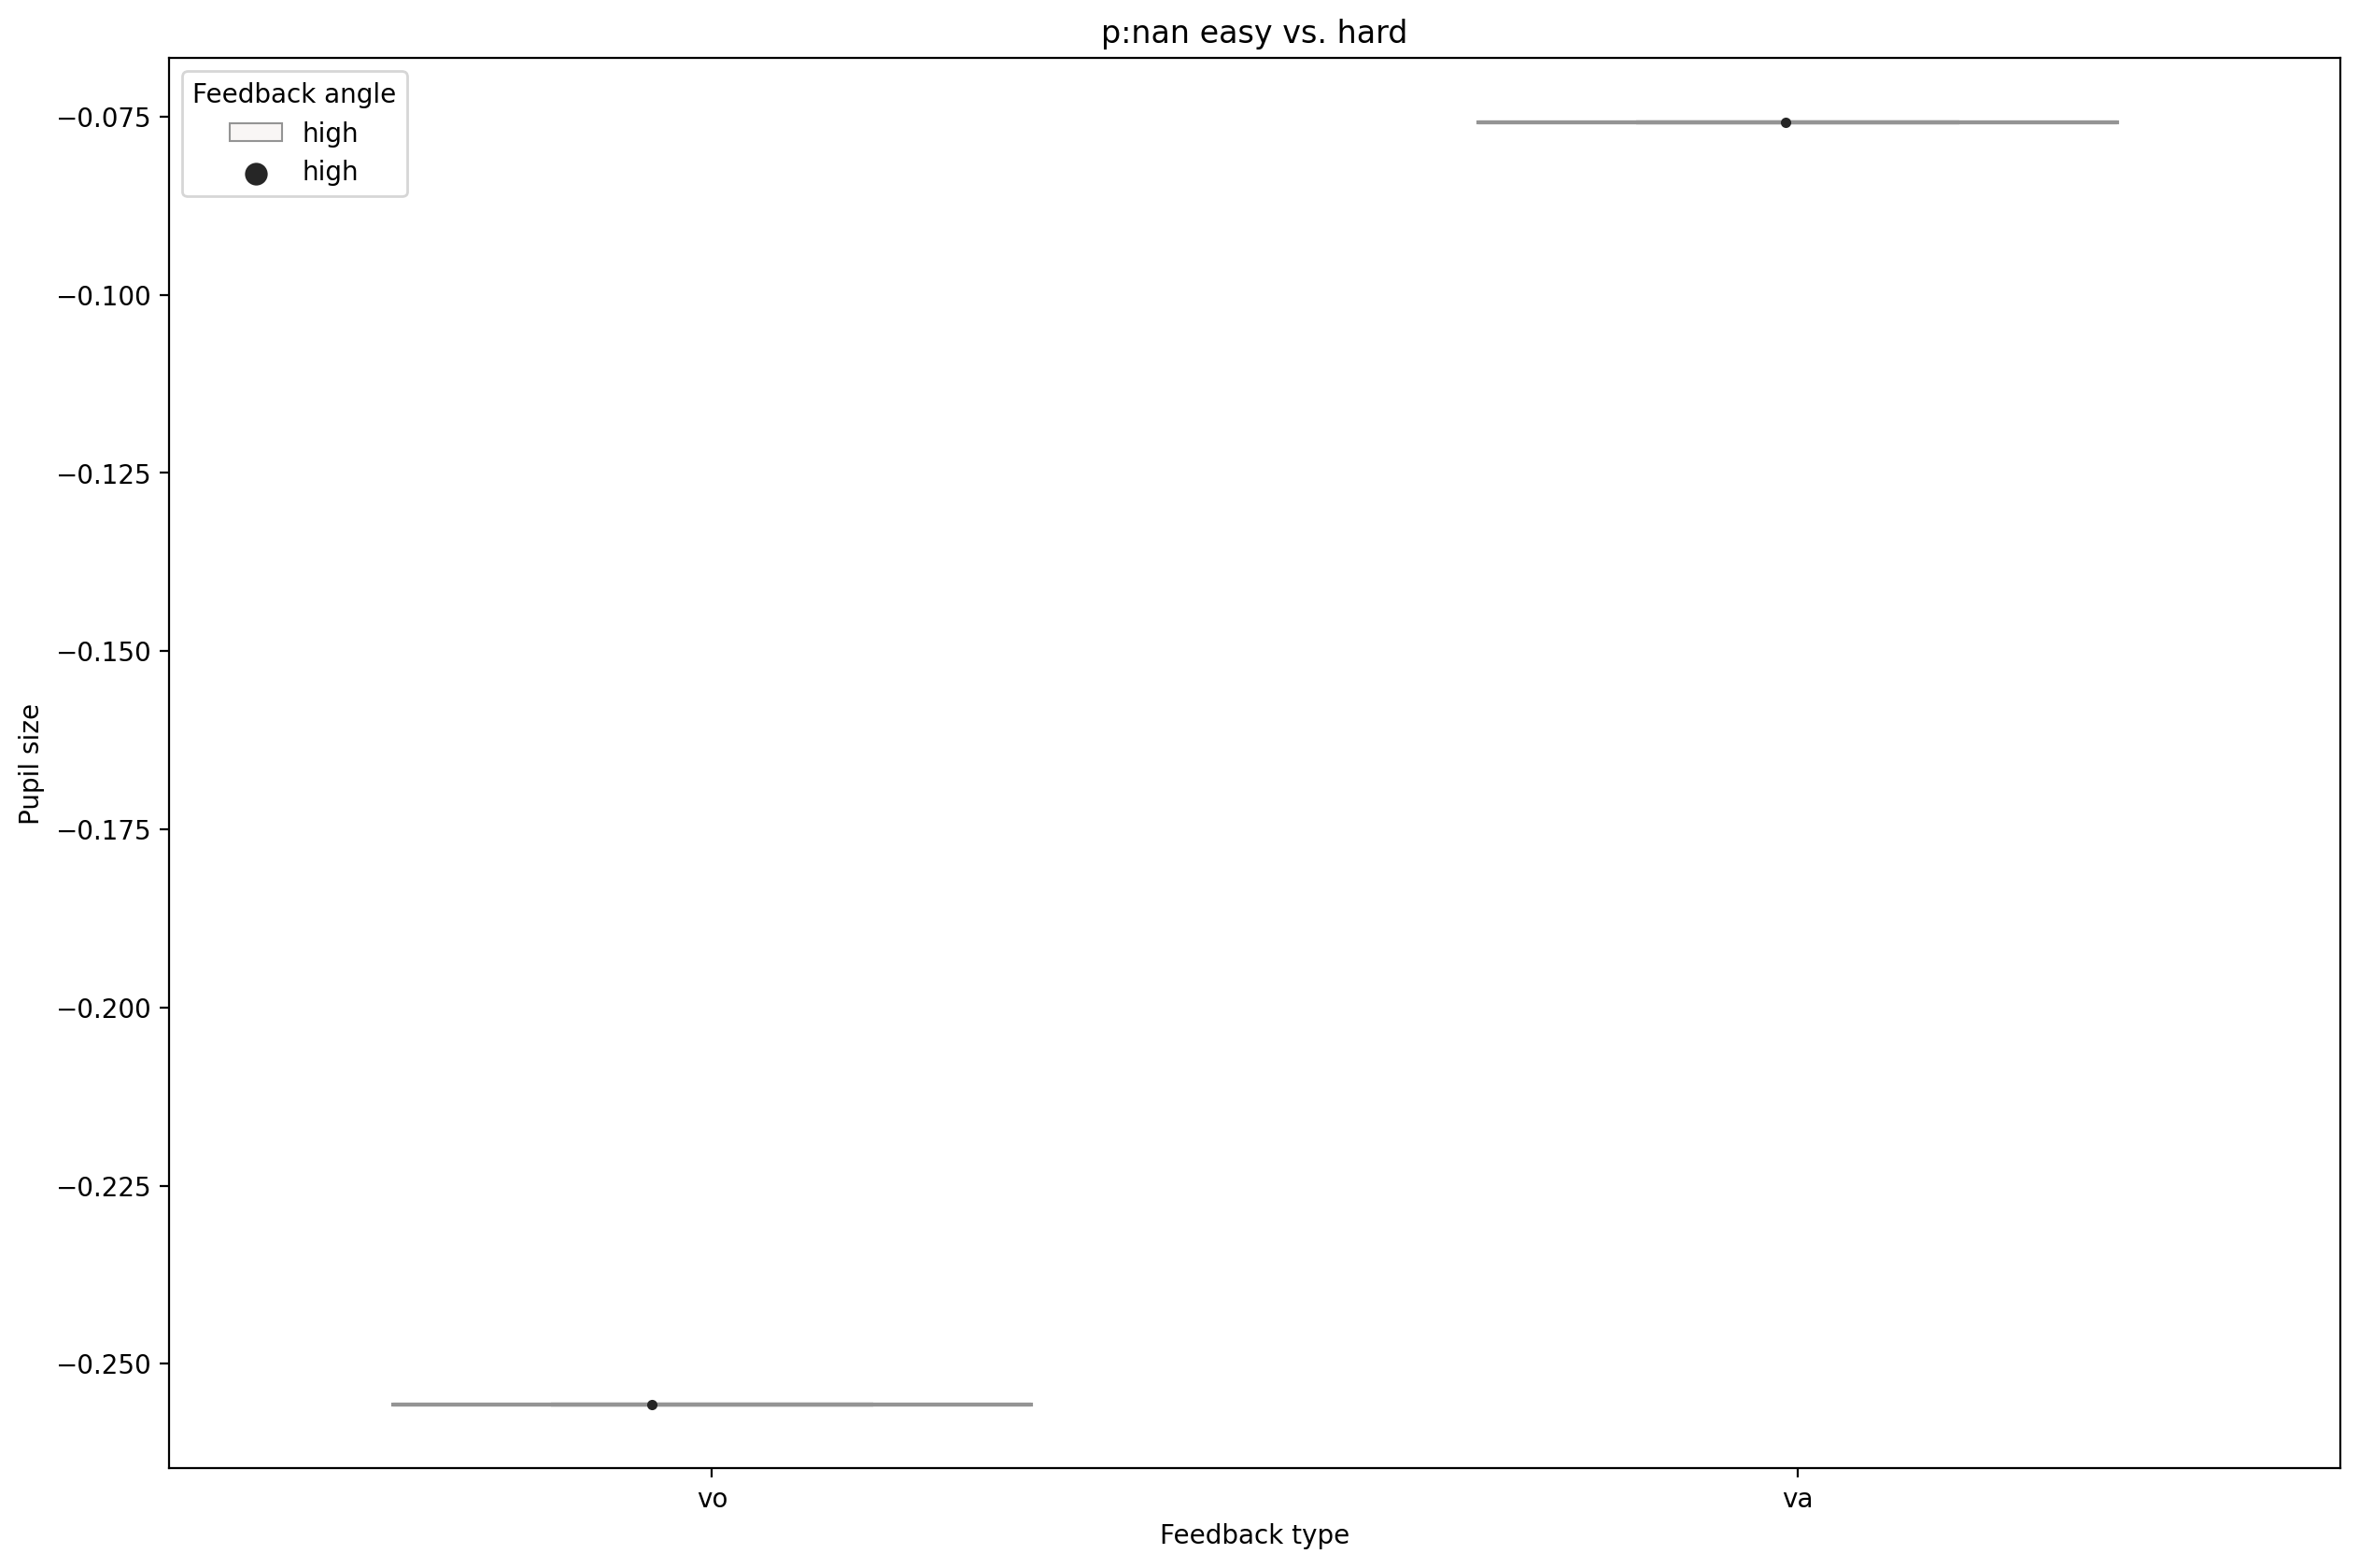

In [ ]:
import seaborn as sns
df_stats = df[df["Percentage bad pupil samples"] < 0.5]
sns.boxplot(data=df_stats,x="Feedback type",y="Pupil size",hue="Feedback angle",whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data=df_stats,x="Feedback type",y="Pupil size",hue="Feedback angle",size=4, color=".3", linewidth=0,dodge=True)

plt.title(f"p:{p_:.3f} easy vs. hard")